# Defense against gradient inversion: Demonstration notebook

- **Gradient reconstruction** is a technique that aims to recover an input image by iteratively optimizing it to match the output of a given neural network, using the gradients of the network with respect to the input. 


- The aim of this notebook is to *demonstrate the security provided by the VB* (Variational Bottleneck) applied to the CNN used for Pneumonia classification.

## Import necessary libraries

In [1]:
import sys
import torch
import cv2
import torch
import bisect
import time

import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F 

from torchvision import datasets, models, transforms
from torch.autograd import Variable
from collections import OrderedDict, defaultdict
from PIL import Image
from numba import jit
from numbers import Number
from copy import deepcopy

##### Importing *Inverting Gradients*' repository

In [2]:
!git clone https://github.com/JonasGeiping/invertinggradients.git
sys.path.insert(0,'invertinggradients')
import inversefed

from inversefed.nn import MetaMonkey
from inversefed.metrics import total_variation as TV
from inversefed.metrics import InceptionScore
from inversefed.medianfilt import MedianPool2d

fatal: destination path 'invertinggradients' already exists and is not an empty directory.


##### Additional transformers

In [3]:
class VariationalBottleneck(torch.nn.Module):
    """
    Implementation inspired by https://github.com/1Konny/VIB-pytorch/blob/master/model.py
    """
    def __init__(self, in_shape, K=256, beta=1e-3, *args, **kwargs):
        super().__init__()
        self.in_shape = in_shape
        self.K = K
        self.beta = beta

        if len(in_shape) == 1: # previous layer is a Linear layer
            enc_in_dim = in_shape[0]
            self.reducer = None
        elif len(in_shape) == 3:
            enc_in_dim = np.prod(in_shape)
            self.reducer = None
        else: 
            enc_in_dim = np.prod(in_shape[1:])
            self.reducer = nn.Conv2d(in_shape[0], 1, 1)

        self.encoder = nn.Linear(enc_in_dim, 2 * self.K)
        self.decoder = nn.Linear(self.K, np.prod(in_shape))

        self.mu = Variable(torch.Tensor(K))
        self.std = Variable(torch.Tensor(K))
        self.out_feats = Variable(torch.Tensor(in_shape))

    def forward(self, x):
        batch_size = x.shape[0]
        x_out = x
        if x.dim() > 2 and x.shape[1] > 1 and self.reducer != None:
            x = self.reducer(x)

        if x.dim() > 2:
            x = x.view(x.size(0), -1)

        statistics = self.encoder(x)
        
        mu = statistics[:, :self.K]
        std = F.softplus(statistics[:, self.K:])
        self.mu = mu
        self.std = std
    
        encoding = self.reparameterize(mu, std) # pull sample from the distribution

        x = self.decoder(encoding.unsqueeze(0))
        x_out = x.view((batch_size, *self.in_shape))
        self.out_feats = x_out

        return x_out


    def reparameterize(self, mu, std):
        def check_number(vector):
            if isinstance(vector, Number):
                return torch.Tensor([vector])
            else:
                return vector

        mu = check_number(mu)
        std = check_number(std)
        eps = Variable(std.data.new(std.size()).normal_().to(mu.device))

        return mu + eps * std

    def loss(self):
        return self.beta * (-0.5*(1+2*self.std.log()-self.mu.pow(2)-self.std.pow(2)).sum(1).mean().div(math.log(2))) 

In [4]:
unnormalize = transforms.Normalize(
                        mean=[-0.4794/0.2384, -0.4794/0.2384, -0.4794/0.2384],
                        std=[1/0.2384, 1/0.2384, 1/0.2384])

grayscale = transforms.Compose([
                        transforms.Grayscale(),
                        transforms.ToTensor()])

## Inversion's setup:

###### Defining CNN's arch and state



* Regular CNN

In [5]:
class ConvNet(torch.nn.Module):
    """ConvNetBN."""

    def __init__(self, width=32, num_classes=2, num_channels=3):
        """Init with width and num classes."""
        super().__init__()
        self.model = torch.nn.Sequential(OrderedDict([
            ('conv0', torch.nn.Conv2d(num_channels, 1 * width, kernel_size=3, padding=1)),
            ('bn0', torch.nn.BatchNorm2d(1 * width)),
            ('relu0', torch.nn.ReLU()),

            ('conv1', torch.nn.Conv2d(1 * width, 2 * width, kernel_size=3, padding=1)),
            ('bn1', torch.nn.BatchNorm2d(2 * width)),
            ('relu1', torch.nn.ReLU()),

            ('conv2', torch.nn.Conv2d(2 * width, 2 * width, kernel_size=3, padding=1)),
            ('bn2', torch.nn.BatchNorm2d(2 * width)),
            ('relu2', torch.nn.ReLU()),

            ('pool1', torch.nn.MaxPool2d(3)),
            ('flatten', torch.nn.Flatten()),
            ('linear', torch.nn.Linear(10952  * width, num_classes))
        ]))

    def forward(self, input):
        return self.model(input)

model = ConvNet()
setup = inversefed.utils.system_startup()
model.to(**setup)   
model.eval()
criterion = nn.CrossEntropyLoss().cuda();

Currently evaluating -------------------------------:
Wednesday, 03. May 2023 12:05PM
CPUs: 6, GPUs: 1 on aml-kaggle-ddelriod.
GPU : Tesla K80


* CNN with Variational Bottleneck

In [6]:
class ConvNetVB(torch.nn.Module):
    """ConvNetBN."""

    def __init__(self, width=32, num_classes=2, num_channels=3):
        """Init with width and num classes."""
        super().__init__()
        self.model = torch.nn.Sequential(OrderedDict([
            ('conv0', torch.nn.Conv2d(num_channels, 1 * width, kernel_size=3, padding=1)),
            ('bn0', torch.nn.BatchNorm2d(1 * width)),
            ('relu0', torch.nn.ReLU()),

            ('conv1', torch.nn.Conv2d(1 * width, 2 * width, kernel_size=3, padding=1)),
            ('bn1', torch.nn.BatchNorm2d(2 * width)),
            ('relu1', torch.nn.ReLU()),

            ('conv2', torch.nn.Conv2d(2 * width, 2 * width, kernel_size=3, padding=1)),
            ('bn2', torch.nn.BatchNorm2d(2 * width)),
            ('relu2', torch.nn.ReLU()),

            ('pool1', torch.nn.MaxPool2d(3)),
            ('flatten', torch.nn.Flatten()),
            ('var_bottleneck', VariationalBottleneck((10952 * width,))),
            ('linear', torch.nn.Linear(10952  * width, num_classes))
        ]))

    def forward(self, input):
        return self.model(input)

model_vb = ConvNetVB()
setup = inversefed.utils.system_startup()
model_vb.to(**setup)   
model_vb.eval()
criterion = nn.CrossEntropyLoss().cuda();

Currently evaluating -------------------------------:
Wednesday, 03. May 2023 12:05PM
CPUs: 6, GPUs: 1 on aml-kaggle-ddelriod.
GPU : Tesla K80


In [7]:
def plot(tensor):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    if tensor.shape[0] == 1:
        return plt.imshow(tensor[0].permute(1, 2, 0).cpu());
    else:
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(12, tensor.shape[0]*12))
        for i, im in enumerate(tensor):
            axes[i].imshow(im.permute(1, 2, 0).cpu());

## Data loading
Using dataloaders, a single image can be used, though

In [8]:
batch_size = 32 
inversefed.utils.set_random_seed(0)
data_dir = {'train': './reconstruct-samples/train',
            'test': './reconstruct-samples/test',
            'valid': './reconstruct-samples/val'} 

In [9]:
data_transforms = {
            'train': transforms.Compose([
                        transforms.Resize((224, 224)),
                        #transforms.CenterCrop(224),
                        #transforms.RandomHorizontalFlip(), # randomly flip and rotate
                        #transforms.RandomRotation(10),
                        transforms.ToTensor(),
                        transforms.Normalize((0.4794, 0.4794, 0.4794), (0.2384, 0.2384, 0.2384)),
                    ]),
    
            'test': transforms.Compose([
                        transforms.Resize((224,224)),
                        transforms.ToTensor(),
                        #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ]),
    
            'valid': transforms.Compose([
                        transforms.Resize((224,224)),
                        transforms.ToTensor(),
                        #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ])
            }

data_set={
        'train': torchvision.datasets.ImageFolder(data_dir['train'] ,data_transforms['train']),
        'test': torchvision.datasets.ImageFolder(data_dir['test'], data_transforms['test']),
        'valid': torchvision.datasets.ImageFolder(data_dir['valid'], data_transforms['valid']),
         }

data_loader={
        'train': torch.utils.data.DataLoader(data_set['train'], batch_size=batch_size,shuffle=False),
        'test': torch.utils.data.DataLoader(data_set['test'], batch_size=batch_size,shuffle=False),
        'valid': torch.utils.data.DataLoader(data_set['valid'], batch_size=batch_size,shuffle=False),
        }

In [10]:
dataiter = iter(data_loader['train'])
images, labels = next(dataiter)
images, labels = images[0].cuda().unsqueeze(0), labels[0].cuda().unsqueeze(0)

###### Compute image's **loss** 


* Regular CNN

In [11]:
output = model(images)
target_loss = criterion(output, labels)
print(f"Computed loss is {target_loss.item():.4f}")

Computed loss is 0.7010


* CNN with Variational Bottleneck

In [12]:
output_vb = model_vb(images)
target_loss_vb = criterion(output_vb, labels)
print(f"Computed loss is {target_loss_vb.item():.4f}")

Computed loss is 0.4023


## Gradient Reconstruction
###### Computing the **gradients** of the target loss with respect to the model parameters

In [13]:
model.zero_grad()
input_gradient = torch.autograd.grad(target_loss, model.parameters())
input_gradient = [grad.detach() for grad in input_gradient]

model_vb.zero_grad()
input_gradient_vb = torch.autograd.grad(target_loss_vb, model_vb.parameters())
input_gradient_vb = [grad.detach() for grad in input_gradient_vb]

###### Definition and configuration of the **inversion**:
1. A dictionary with the params of the "machine"
2. Additional configuration such as number of images or the dataset's mean and std  

In [19]:
config = dict(signed=True,
              boxed=True,
              cost_fn='sim',
              indices='def',
              weights='equal',
              lr=0.1,
              optim='adam',
              restarts=1,
              max_iterations=2000,
              total_variation=1e-6,
              init='randn', 
              filter='none',
              lr_decay=True,
              scoring_choice='loss')

num_images = 1
dm_values = [0.4794, 0.4794, 0.4794]
ds_values = [0.2384, 0.2384, 0.2384]
dm = torch.tensor(dm_values).unsqueeze(1).unsqueeze(1).cuda()
ds = torch.tensor(ds_values).unsqueeze(1).unsqueeze(1).cuda()

rec_machine = GradientReconstructor(model, (dm, ds), config, num_images=num_images)
output, stats, all_iters = rec_machine.reconstruct(input_gradient, labels, img_shape=(3, 224, 224))

rec_machine_vb = GradientReconstructor(model_vb, (dm, ds), config, num_images=num_images)
output_vb, stats_vb, all_iters_vb = rec_machine_vb.reconstruct(input_gradient_vb, labels, img_shape=(3, 224, 224))

It: 0. Rec. loss: 10.0000.
It: 250. Rec. loss: 0.0914.
It: 500. Rec. loss: 0.0726.
It: 750. Rec. loss: 0.0707.
Recovery interrupted manually in iteration 797!
Choosing optimal result ...
Optimal result score: 0.0787
tensor(0)
Total time: 273.4962365627289.


## Metrics
Comparing the inversions of a regular net against the encoder's approach

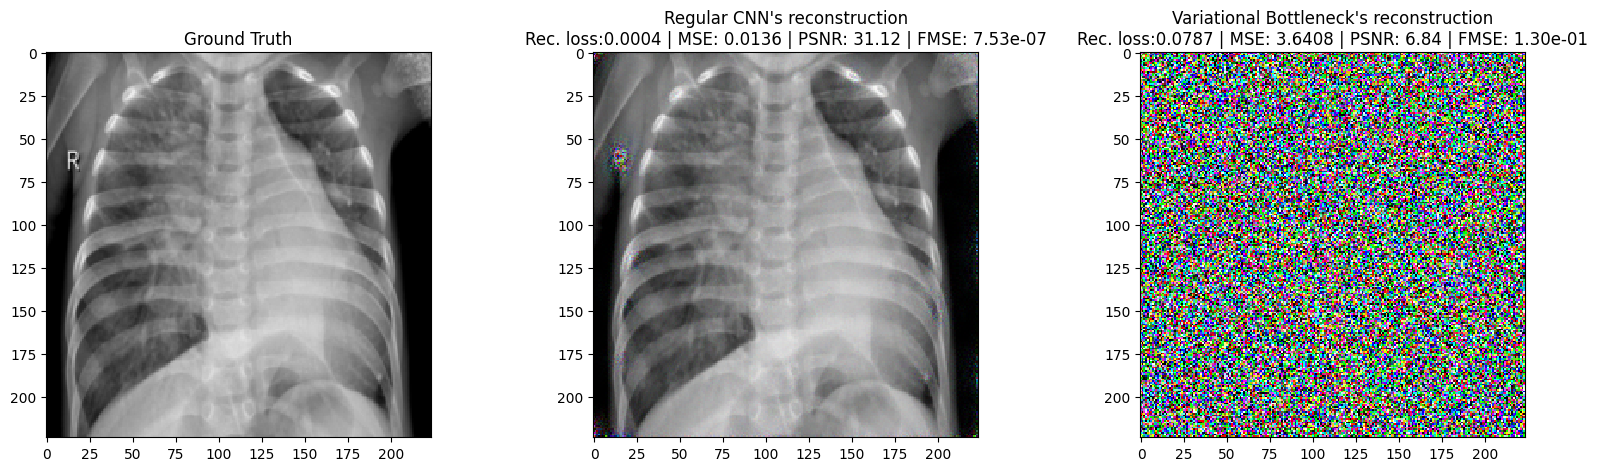

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, ax in enumerate(axes):
    if i == 0:
        img = unnormalize(images).squeeze(0).permute(1,2,0)
        title = "Ground Truth"
        ax.imshow(img.cpu().numpy(), interpolation='nearest')
        ax.set_title(title)
    if i == 1:
        img = unnormalize(output).squeeze(0).permute(1,2,0)
        mse = (output.detach() - images).pow(2).mean()
        feat_mse = (model(output.detach())- model(images)).pow(2).mean()  
        psnr = inversefed.metrics.psnr(output, images, factor=1/ds)
        title = f"Regular CNN's reconstruction\nRec. loss:{stats['opt']:2.4f} | MSE: {mse:2.4f} | PSNR: {psnr:4.2f} | FMSE: {feat_mse:2.2e}"
        ax.imshow(img.cpu().numpy(), interpolation='nearest')
        ax.set_title(title)
    elif i == 2:
        img = unnormalize(output_vb).squeeze(0).permute(1,2,0)
        mse_vb = (output_vb.detach() - images).pow(2).mean()
        feat_vb_mse = (model_vb(output_vb.detach())- model_vb(images)).pow(2).mean()  
        psnr_vb = inversefed.metrics.psnr(output_vb, images, factor=1/ds)
        title = f"Variational Bottleneck's reconstruction\nRec. loss:{stats_vb['opt']:2.4f} | MSE: {mse_vb:2.4f} | PSNR: {psnr_vb:4.2f} | FMSE: {feat_vb_mse:2.2e}"
        ax.imshow(img.cpu().numpy(), interpolation='nearest')
        ax.set_title(title)

plt.show()


## Post-Processing
**Enhancement** of the reconstructed image with the **imadjust** method

In [62]:
@jit
def imadjust(src, tol=5, vin=[0,255], vout=(0,255)):
    # src : input one-layer image (numpy array)
    # tol : tolerance, from 0 to 100.
    # vin  : src image bounds
    # vout : dst image bounds
    # return : output img

    assert len(src.shape) == 2 ,'Input image should be 2-dims'

    tol = max(0, min(100, tol))

    if tol > 0:
        # Compute in and out limits
        # Histogram
        hist = np.histogram(src,bins=list(range(256)),range=(0,255))[0]

        # Cumulative histogram
        cum = hist.copy()
        for i in range(1, len(hist)): cum[i] = cum[i - 1] + hist[i]

        # Compute bounds
        total = src.shape[0] * src.shape[1]
        low_bound = total * tol / 100
        upp_bound = total * (100 - tol) / 100
        vin[0] = bisect.bisect_left(cum, low_bound)
        vin[1] = bisect.bisect_left(cum, upp_bound)

    # Stretching
    scale = (vout[1] - vout[0]) / (vin[1] - vin[0])
    vs = src-vin[0]
    vs[src<vin[0]]=0
    vd = vs*scale+0.5 + vout[0]
    vd[vd>vout[1]] = vout[1]
    dst = vd

    return dst

In [89]:
img_pil = Image.fromarray((img*255).astype(np.uint8))                   
img_gray = grayscale(img_pil).squeeze(0).numpy()*255

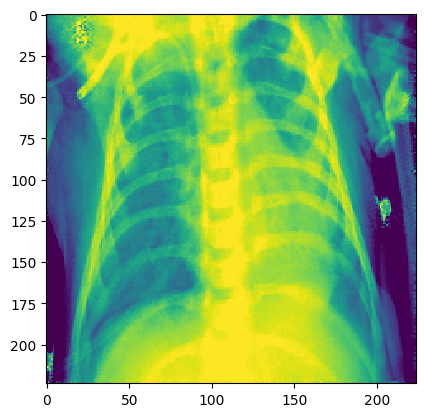

In [91]:
img_adjust = imadjust(img_gray.astype(np.uint8))
plt.imshow(img_adjust, interpolation='nearest')

In [14]:
"""Mechanisms for image reconstruction from parameter gradients."""
DEFAULT_CONFIG = dict(signed=False,
                      boxed=True,
                      cost_fn='sim',
                      indices='def',
                      weights='equal',
                      lr=0.1,
                      optim='adam',
                      restarts=1,
                      max_iterations=4800,
                      total_variation=1e-1,
                      init='randn',
                      filter='none',
                      lr_decay=True,
                      scoring_choice='loss')

def _label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def _validate_config(config):
    for key in DEFAULT_CONFIG.keys():
        if config.get(key) is None:
            config[key] = DEFAULT_CONFIG[key]
    for key in config.keys():
        if DEFAULT_CONFIG.get(key) is None:
            raise ValueError(f'Deprecated key in config dict: {key}!')
    return config


class GradientReconstructor():
    """Instantiate a reconstruction algorithm."""

    def __init__(self, model, mean_std=(0.0, 1.0), config=DEFAULT_CONFIG, num_images=1):
        """Initialize with algorithm setup."""
        self.config = _validate_config(config)
        self.model = model
        self.setup = dict(device=next(model.parameters()).device, dtype=next(model.parameters()).dtype)

        self.mean_std = mean_std
        self.num_images = num_images

        if self.config['scoring_choice'] == 'inception':
            self.inception = InceptionScore(batch_size=1, setup=self.setup)

        self.loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
        self.iDLG = True

    def reconstruct(self, input_data, labels, img_shape=(3, 32, 32), dryrun=False, eval=True, tol=None):
        """Reconstruct image from gradient."""
        start_time = time.time()
        if eval:
            self.model.eval()


        stats = defaultdict(list)
        x = self._init_images(img_shape)
        scores = torch.zeros(self.config['restarts'])

        if labels is None:
            if self.num_images == 1 and self.iDLG:
                # iDLG trick:
                last_weight_min = torch.argmin(torch.sum(input_data[-2], dim=-1), dim=-1)
                labels = last_weight_min.detach().reshape((1,)).requires_grad_(False)
                self.reconstruct_label = False
            else:
                # DLG label recovery
                # However this also improves conditioning for some LBFGS cases
                self.reconstruct_label = True

                def loss_fn(pred, labels):
                    labels = torch.nn.functional.softmax(labels, dim=-1)
                    return torch.mean(torch.sum(- labels * torch.nn.functional.log_softmax(pred, dim=-1), 1))
                self.loss_fn = loss_fn
        else:
            assert labels.shape[0] == self.num_images
            self.reconstruct_label = False

        try:
            for trial in range(self.config['restarts']):
                x_trial, labels, trials = self._run_trial(x[trial], input_data, labels, dryrun=dryrun)
                # Finalize
                scores[trial] = self._score_trial(x_trial, input_data, labels)
                x[trial] = x_trial
                if tol is not None and scores[trial] <= tol:
                    break
                if dryrun:
                    break
        except KeyboardInterrupt:
            print('Trial procedure manually interruped.')
            pass

        # Choose optimal result:
        if self.config['scoring_choice'] in ['pixelmean', 'pixelmedian']:
            x_optimal, stats = self._average_trials(x, labels, input_data, stats)
        else:
            print('Choosing optimal result ...')
            scores = scores[torch.isfinite(scores)]  # guard against NaN/-Inf scores?
            optimal_index = torch.argmin(scores)
            print(f'Optimal result score: {scores[optimal_index]:2.4f}')
            print(optimal_index)
            stats['opt'] = scores[optimal_index].item()
            x_optimal = x[optimal_index]

        print(f'Total time: {time.time()-start_time}.')
        return x_optimal.detach(), stats, trials

    def _init_images(self, img_shape):
        if self.config['init'] == 'randn':
            return torch.randn((self.config['restarts'], self.num_images, *img_shape), **self.setup)
        elif self.config['init'] == 'rand':
            return (torch.rand((self.config['restarts'], self.num_images, *img_shape), **self.setup) - 0.5) * 2
        elif self.config['init'] == 'zeros':
            return torch.zeros((self.config['restarts'], self.num_images, *img_shape), **self.setup)
        else:
            raise ValueError()

    def _run_trial(self, x_trial, input_data, labels, dryrun=False):
        x_trial.requires_grad = True
        iters = []
        if self.reconstruct_label:
            output_test = self.model(x_trial)
            labels = torch.randn(output_test.shape[1]).to(**self.setup).requires_grad_(True)

            if self.config['optim'] == 'adam':
                optimizer = torch.optim.Adam([x_trial, labels], lr=self.config['lr'])
            elif self.config['optim'] == 'sgd':  # actually gd
                optimizer = torch.optim.SGD([x_trial, labels], lr=0.01, momentum=0.9, nesterov=True)
            elif self.config['optim'] == 'LBFGS':
                optimizer = torch.optim.LBFGS([x_trial, labels])
            else:
                raise ValueError()
        else:
            if self.config['optim'] == 'adam':
                optimizer = torch.optim.Adam([x_trial], lr=self.config['lr'])
            elif self.config['optim'] == 'sgd':  # actually gd
                optimizer = torch.optim.SGD([x_trial], lr=0.01, momentum=0.9, nesterov=True)
            elif self.config['optim'] == 'LBFGS':
                optimizer = torch.optim.LBFGS([x_trial])
            else:
                raise ValueError()

        max_iterations = self.config['max_iterations']
        dm, ds = self.mean_std
        if self.config['lr_decay']:
            scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                             milestones=[max_iterations // 4.5,
                                                                         max_iterations // 2.25,
                                                                         max_iterations // 1.5,
                                                                         max_iterations // 1], gamma=0.25)  
        try:
            best_score = 10
            best_img = None
        
            for iteration in range(max_iterations):
                closure = self._gradient_closure(optimizer, x_trial, input_data, labels)
                rec_loss = optimizer.step(closure)
                if self.config['lr_decay']:
                    scheduler.step()

                with torch.no_grad():
                    # Project into image space
                    if self.config['boxed']:
                        x_trial.data = torch.max(torch.min(x_trial, (1 - dm) / ds), -dm / ds)

                    if (iteration + 1 == max_iterations) or iteration % 250 == 0:
                        print(f'It: {iteration}. Rec. loss: {best_score:2.4f}.')
                    
                    if (iteration +1) < 50:
                        iters.append(x_trial.detach())

                    if (iteration + 1) % 250 == 0:
                        if self.config['filter'] == 'none':
                            pass
                        elif self.config['filter'] == 'median':
                            x_trial.data = MedianPool2d(kernel_size=3, stride=1, padding=1, same=False)(x_trial)
                        else:
                            raise ValueError()
                    if rec_loss<best_score:
                      best_score = rec_loss 
                      best_img = x_trial.detach()
                  
                if dryrun:
                    break
        except KeyboardInterrupt:
            print(f'Recovery interrupted manually in iteration {iteration}!')
            pass
        return x_trial.detach(), labels, iters

    def _gradient_closure(self, optimizer, x_trial, input_gradient, label):

        def closure():
            optimizer.zero_grad()
            self.model.zero_grad()
            loss = self.loss_fn(self.model(x_trial), label)
            gradient = torch.autograd.grad(loss, self.model.parameters(), create_graph=True)
            rec_loss = reconstruction_costs([gradient], input_gradient,
                                            cost_fn=self.config['cost_fn'], indices=self.config['indices'],
                                            weights=self.config['weights'])

            if self.config['total_variation'] > 0:
                rec_loss += self.config['total_variation'] * TV(x_trial)
            rec_loss.backward()
            if self.config['signed']:
                x_trial.grad.sign_()
            return rec_loss
        return closure

    def _score_trial(self, x_trial, input_gradient, label):
        if self.config['scoring_choice'] == 'loss':
            self.model.zero_grad()
            x_trial.grad = None
            loss = self.loss_fn(self.model(x_trial), label)
            gradient = torch.autograd.grad(loss, self.model.parameters(), create_graph=False)
            return reconstruction_costs([gradient], input_gradient,
                                        cost_fn=self.config['cost_fn'], indices=self.config['indices'],
                                        weights=self.config['weights'])
        elif self.config['scoring_choice'] == 'tv':
            return TV(x_trial)
        elif self.config['scoring_choice'] == 'inception':
            # We do not care about diversity here!
            return self.inception(x_trial)
        elif self.config['scoring_choice'] in ['pixelmean', 'pixelmedian']:
            return 0.0
        else:
            raise ValueError()

    def _average_trials(self, x, labels, input_data, stats):
        print(f'Computing a combined result via {self.config["scoring_choice"]} ...')
        if self.config['scoring_choice'] == 'pixelmedian':
            x_optimal, _ = x.median(dim=0, keepdims=False)
        elif self.config['scoring_choice'] == 'pixelmean':
            x_optimal = x.mean(dim=0, keepdims=False)

        self.model.zero_grad()
        if self.reconstruct_label:
            labels = self.model(x_optimal).softmax(dim=1)
        loss = self.loss_fn(self.model(x_optimal), labels)
        gradient = torch.autograd.grad(loss, self.model.parameters(), create_graph=False)
        stats['opt'] = reconstruction_costs([gradient], input_data,
                                            cost_fn=self.config['cost_fn'],
                                            indices=self.config['indices'],
                                            weights=self.config['weights'])
        print(f'Optimal result score: {stats["opt"]:2.4f}')
        return x_optimal, stats



class FedAvgReconstructor(GradientReconstructor):
    """Reconstruct an image from weights after n gradient descent steps."""

    def __init__(self, model, mean_std=(0.0, 1.0), local_steps=2, local_lr=1e-4,
                 config=DEFAULT_CONFIG, num_images=1, use_updates=True, batch_size=0):
        """Initialize with model, (mean, std) and config."""
        super().__init__(model, mean_std, config, num_images)
        self.local_steps = local_steps
        self.local_lr = local_lr
        self.use_updates = use_updates
        self.batch_size = batch_size

    def _gradient_closure(self, optimizer, x_trial, input_parameters, labels):
        def closure():
            optimizer.zero_grad()
            self.model.zero_grad()
            parameters = loss_steps(self.model, x_trial, labels, loss_fn=self.loss_fn,
                                    local_steps=self.local_steps, lr=self.local_lr,
                                    use_updates=self.use_updates,
                                    batch_size=self.batch_size)
            rec_loss = reconstruction_costs([parameters], input_parameters,
                                            cost_fn=self.config['cost_fn'], indices=self.config['indices'],
                                            weights=self.config['weights'])

            if self.config['total_variation'] > 0:
                rec_loss += self.config['total_variation'] * TV(x_trial)
            rec_loss.backward()
            if self.config['signed']:
                x_trial.grad.sign_()
            return rec_loss
        return closure

    def _score_trial(self, x_trial, input_parameters, labels):
        if self.config['scoring_choice'] == 'loss':
            self.model.zero_grad()
            parameters = loss_steps(self.model, x_trial, labels, loss_fn=self.loss_fn,
                                    local_steps=self.local_steps, lr=self.local_lr, use_updates=self.use_updates)
            return reconstruction_costs([parameters], input_parameters,
                                        cost_fn=self.config['cost_fn'], indices=self.config['indices'],
                                        weights=self.config['weights'])
        elif self.config['scoring_choice'] == 'tv':
            return TV(x_trial)
        elif self.config['scoring_choice'] == 'inception':
            # We do not care about diversity here!
            return self.inception(x_trial)


def loss_steps(model, inputs, labels, loss_fn=torch.nn.CrossEntropyLoss(), lr=1e-4, local_steps=4, use_updates=True, batch_size=0):
    """Take a few gradient descent steps to fit the model to the given input."""
    patched_model = MetaMonkey(model)
    if use_updates:
        patched_model_origin = deepcopy(patched_model)
    for i in range(local_steps):
        if batch_size == 0:
            outputs = patched_model(inputs, patched_model.parameters)
            labels_ = labels
        else:
            idx = i % (inputs.shape[0] // batch_size)
            outputs = patched_model(inputs[idx * batch_size:(idx + 1) * batch_size], patched_model.parameters)
            labels_ = labels[idx * batch_size:(idx + 1) * batch_size]
        loss = loss_fn(outputs, labels_).sum()
        grad = torch.autograd.grad(loss, patched_model.parameters.values(),
                                   retain_graph=True, create_graph=True, only_inputs=True)

        patched_model.parameters = OrderedDict((name, param - lr * grad_part)
                                               for ((name, param), grad_part)
                                               in zip(patched_model.parameters.items(), grad))

    if use_updates:
        patched_model.parameters = OrderedDict((name, param - param_origin)
                                               for ((name, param), (name_origin, param_origin))
                                               in zip(patched_model.parameters.items(), patched_model_origin.parameters.items()))
    return list(patched_model.parameters.values())


def reconstruction_costs(gradients, input_gradient, cost_fn='l2', indices='def', weights='equal'):
    """Input gradient is given data."""
    if isinstance(indices, list):
        pass
    elif indices == 'def':
        indices = torch.arange(len(input_gradient))
    elif indices == 'batch':
        indices = torch.randperm(len(input_gradient))[:8]
    elif indices == 'topk-1':
        _, indices = torch.topk(torch.stack([p.norm() for p in input_gradient], dim=0), 4)
    elif indices == 'top10':
        _, indices = torch.topk(torch.stack([p.norm() for p in input_gradient], dim=0), 10)
    elif indices == 'top50':
        _, indices = torch.topk(torch.stack([p.norm() for p in input_gradient], dim=0), 50)
    elif indices in ['first', 'first4']:
        indices = torch.arange(0, 4)
    elif indices == 'first5':
        indices = torch.arange(0, 5)
    elif indices == 'first10':
        indices = torch.arange(0, 10)
    elif indices == 'first50':
        indices = torch.arange(0, 50)
    elif indices == 'last5':
        indices = torch.arange(len(input_gradient))[-5:]
    elif indices == 'last10':
        indices = torch.arange(len(input_gradient))[-10:]
    elif indices == 'last50':
        indices = torch.arange(len(input_gradient))[-50:]
    else:
        raise ValueError()

    ex = input_gradient[0]
    if weights == 'linear':
        weights = torch.arange(len(input_gradient), 0, -1, dtype=ex.dtype, device=ex.device) / len(input_gradient)
    elif weights == 'exp':
        weights = torch.arange(len(input_gradient), 0, -1, dtype=ex.dtype, device=ex.device)
        weights = weights.softmax(dim=0)
        weights = weights / weights[0]
    else:
        weights = input_gradient[0].new_ones(len(input_gradient))

    total_costs = 0
    for trial_gradient in gradients:
        pnorm = [0, 0]
        costs = 0
        if indices == 'topk-2':
            _, indices = torch.topk(torch.stack([p.norm().detach() for p in trial_gradient], dim=0), 4)
        for i in indices:
            if cost_fn == 'l2':
                costs += ((trial_gradient[i] - input_gradient[i]).pow(2)).sum() * weights[i]
            elif cost_fn == 'l1':
                costs += ((trial_gradient[i] - input_gradient[i]).abs()).sum() * weights[i]
            elif cost_fn == 'max':
                costs += ((trial_gradient[i] - input_gradient[i]).abs()).max() * weights[i]
            elif cost_fn == 'sim':
                costs -= (trial_gradient[i] * input_gradient[i]).sum() * weights[i]
                pnorm[0] += trial_gradient[i].pow(2).sum() * weights[i]
                pnorm[1] += input_gradient[i].pow(2).sum() * weights[i]
            elif cost_fn == 'simlocal':
                costs += 1 - torch.nn.functional.cosine_similarity(trial_gradient[i].flatten(),
                                                                   input_gradient[i].flatten(),
                                                                   0, 1e-10) * weights[i]
        if cost_fn == 'sim':
            costs = 1 + costs / pnorm[0].sqrt() / pnorm[1].sqrt()

        # Accumulate final costs
        total_costs += costs
    return total_costs / len(gradients)
